# Business case

__Below analysis is conducted to support the business planning process by creating monthly predictions of sales.__

In the beginning, the tools used are imported.
<br>Here is a brief description of packages used in the analysis:
- Pandas, NumPy - data manipulation and linear algebra
- Scipy - statistical tools for distribution and data transformation
- Sklearn - generating predictions with the regression model
- Matplotlib, Seaborn - visualization

In [33]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy import stats
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
%matplotlib inline
color = sns.color_palette()
sns.set_style('darkgrid')


def ignore_warn(*args, **kwargs):
    pass


warnings.warn = ignore_warn

## Importing the data & first look

Reading the task description, we know that our X train data contains product key, date, and independent variables containing historical expenditures. <br>The Y_train table has 'y' as a target variable of historical sales instead of expenditures. <br>We also know that comma is used as decimal separator. 
<br><br>After importing the data, we need to take a look at it to see how to proceed with preprocessing

In [2]:
# Importing train data
X_train = pd.read_csv('X_train.csv', sep=';') # import the csv file
Y_train = pd.read_csv('Y_train.csv', sep=';') 

In [3]:
X_train.head()

,key,date,x1,x2,x3,x4,x5,x6,x7,x8,...,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112
0,683,01Jan2012,"0,793085198",0,"0,690345988",0,NaN,NaN,"502,8938934","10235,63778",...,"0,053508839","120,6698137","0,955508665","616,883023","200,1444784",0,"20,3915535","0,509712749","216,8512449","56,13990644"
1,683,01Feb2012,0,"0,000685706","0,59013279",0,"362,0213091",NaN,"72,83316004","88,79301167",...,"112,0743855","69,94318916","2,704237409","292,9347136","138,2411344",0,"15,316564","2,526961805","39,45195976","7,172635353"
2,683,01Mar2012,0,0,0,"0,672650825",NaN,NaN,"880,9174065","553,998042",...,"0,998246889","273,2131346",0,"92,26481145","100,972356",0,"12,77405335","0,242972715","35,22626415","50,61438334"
3,683,01Apr2012,0,0,0,"0,022905556",NaN,"6,711942805","150,7788122","11,95185585",...,"182,0479968","18,27207718","-0,357519789","5,272195727","49,72592447",0,"17,90442674","29,43777276","5,591308778",0
4,683,01May2012,0,0,0,0,NaN,NaN,"5116,833341","114,048014",...,"15,8362768","1629,479264","59,61333848","0,06075251","4,878556073",0,"14,08130257","0,125393169","5,872890949",0


In [4]:
X_train.dtypes

key      int64
date    object
x1      object
x2      object
x3      object
         ...  
x108    object
x109    object
x110    object
x111    object
x112    object
Length: 114, dtype: object

In [5]:
Y_train.head()

,key,date,y
0,683,01Jan2012,"1430,314968"
1,683,01Feb2012,0
2,683,01Mar2012,"5088,5319"
3,683,01Apr2012,"2837,756051"
4,683,01May2012,"51,31168875"


In [6]:
Y_train.dtypes

key      int64
date    object
y       object
dtype: object

## Preprocessing

The first step is to replace comas with dots so the numbers can be interpreted as numerical values by the tools.
<br> Then, we have to change the type of columns - 'x1' to 'x112' as float and 'date' as a date or numeric ordinal form.
<br> There are also missing values in expenditures columns so we fill them with zeroes for better interpretation.
<br> Same steps go for Y_train dataframe as well as X_test data.

In [7]:
# preprocessing train data

X_train.iloc[:, 2:] = X_train.iloc[:, 2:].apply(
    lambda x: x.str.replace(',', '.')) # replace commas with dots as decimal separator
X_train.iloc[:, 2:] = X_train.iloc[:, 2:].astype('float') # change numerical column's type to float
X_train['date'] = pd.to_datetime(X_train['date']) 
X_train['date'] = X_train['date'].map(dt.datetime.toordinal) # transform the date to for scikit learn algorithms use
X_train = X_train.fillna(0) # fill missing values with zeroes

# same below but for target data file
Y_train['y'] = Y_train['y'].apply(lambda x: str(x).replace(',', '.'))
Y_train['y'] = Y_train['y'].astype('float') 
Y_train['date'] = pd.to_datetime(Y_train['date'])
Y_train['date'] = Y_train['date'].map(dt.datetime.toordinal)
Y_train['y'] = Y_train['y'].fillna(0)

In [8]:
# Importing & preprocessing test data

X_test = pd.read_csv('X_test.csv', sep=';')
X_test.iloc[:, 2:] = X_test.iloc[:, 2:].apply(
    lambda x: x.str.replace(',', '.')) 
X_test.iloc[:, 2:] = X_test.iloc[:, 2:].astype('float')
X_test['date'] = pd.to_datetime(X_test['date'])
X_test['date'] = X_test['date'].map(dt.datetime.toordinal)
X_test = X_test.fillna(0)

In [9]:
X_train.head()

,key,date,x1,x2,x3,x4,x5,x6,x7,x8,...,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112
0,683,734503,0.793085,0.000000,0.690346,0.000000,0.000000,0.000000,502.893893,10235.637780,...,0.053509,120.669814,0.955509,616.883023,200.144478,0.0,20.391554,0.509713,216.851245,56.139906
1,683,734534,0.000000,0.000686,0.590133,0.000000,362.021309,0.000000,72.833160,88.793012,...,112.074386,69.943189,2.704237,292.934714,138.241134,0.0,15.316564,2.526962,39.451960,7.172635
2,683,734563,0.000000,0.000000,0.000000,0.672651,0.000000,0.000000,880.917406,553.998042,...,0.998247,273.213135,0.000000,92.264811,100.972356,0.0,12.774053,0.242973,35.226264,50.614383
3,683,734594,0.000000,0.000000,0.000000,0.022906,0.000000,6.711943,150.778812,11.951856,...,182.047997,18.272077,-0.357520,5.272196,49.725924,0.0,17.904427,29.437773,5.591309,0.000000
4,683,734624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5116.833341,114.048014,...,15.836277,1629.479264,59.613338,0.060753,4.878556,0.0,14.081303,0.125393,5.872891,0.000000


In [10]:
Y_train.head()

,key,date,y
0,683,734503,1430.314968
1,683,734534,0.000000
2,683,734563,5088.531900
3,683,734594,2837.756051
4,683,734624,51.311689


## Feature selection

After cleaning the data we can now check the relationship between each value in train data.
<br> This is important for feature selection because we want to reduce dimensions of data to avoid overfitting, long computation times, and get rid of badly influencing columns.
<br> We look for columns with the highest Pearson factor value.

In [11]:
corr_X_train = X_train.merge(Y_train, on=['key', 'date']).corr() # checking the relationship between each input variable and the target 
corr_X_train.style.background_gradient(cmap='PuBu')

We can see that only a few columns have a significant correlation value.
<br> We set the threshold of 0.13 in correlation with the 'y' column and choose columns with a value higher than the threshold
<br> To achieve this we use SelectKBest function from Scikit-learn package

In [12]:
# feature seletion for the strongest variables

selector = SelectKBest(score_func=f_regression, k=6) # we select 6 significant variables out of 113
X_new = selector.fit_transform(X_train.loc[:, 'date':'x112'], Y_train.y)
selected_features = pd.DataFrame(selector.inverse_transform(
    X_new), index=X_train.index, columns=X_train.loc[:, 'date':'x112'].columns.tolist())
selected_columns = selected_features.columns[selected_features.var() != 0]
selected_features = selected_features[selected_columns]
selected_features

,date,x10,x17,x22,x88,x101
0,734503.0,3190.003651,0.000000,-7.009597,2935.746468,2483.197938
1,734534.0,2650.403762,0.000000,182.522388,2269.404233,2588.661911
2,734563.0,2737.479632,0.000000,71.534699,2406.631651,3199.137392
3,734594.0,3492.642102,0.000000,82.488252,3116.009696,2334.295931
4,734624.0,2591.599732,0.000000,74.886927,2286.291490,3669.944623
...,...,...,...,...,...,...
8432,736726.0,8466.054268,6139.511141,209.275409,2947.428662,8902.156016
8433,736754.0,9052.754307,4923.838551,219.885526,3236.812001,9921.481770
8434,736785.0,7938.102330,6144.648951,134.625022,2187.324868,8536.513312
8435,736815.0,9805.914396,6413.394496,268.473893,2511.862772,10371.554770


In [13]:
X_train_ID = X_train['key'] #saving products IDs
selected_features['key'] = X_train_ID
selected_features = selected_features[[
    'key', 'date', 'x10', 'x17', 'x22', 'x88', 'x101']]
df = selected_features.merge(Y_train, on=['key', 'date']) # creating final dataframe with train data
df.head()

,key,date,x10,x17,x22,x88,x101,y
0,683,734503.0,3190.003651,0.0,-7.009597,2935.746468,2483.197938,1430.314968
1,683,734534.0,2650.403762,0.0,182.522388,2269.404233,2588.661911,0.000000
2,683,734563.0,2737.479632,0.0,71.534699,2406.631651,3199.137392,5088.531900
3,683,734594.0,3492.642102,0.0,82.488252,3116.009696,2334.295931,2837.756051
4,683,734624.0,2591.599732,0.0,74.886927,2286.291490,3669.944623,51.311689


The dataframe above we will use for further feature engineering.
<br>We have to create the same looking table for test data predictions:

In [14]:
X_test = X_test[selected_features.columns.tolist()] # same goes for test data
X_test_ID = X_test['key']
X_test.drop('key', axis=1, inplace=True)
X_test.head()

,date,x10,x17,x22,x88,x101
0,736876,7599.854339,798.069372,25.079849,5976.264094,7279.604101
1,736907,7129.983016,961.357287,40.379627,5683.598011,3777.535755
2,736938,3678.029954,841.656146,32.560699,2838.761331,5355.291239
3,736968,5274.149878,922.234490,44.605913,4253.539961,4923.854158
4,736999,4552.412721,1105.512624,256.098225,3461.994497,5828.418017


## Feature engineering

Now, let's check the distribution of each value to find outliers wich could disturb predictions.

In [15]:
df_ID = df['key']
df['date'] = df['date'].astype(int).map(dt.datetime.fromordinal) # changing date format once again for better graphical representation
df = df[(df['y'] != 0) & (df['y'] < 10000)] #correcting the distribution of target variable
df.drop('key', axis=1, inplace=True) # we drop key column for now

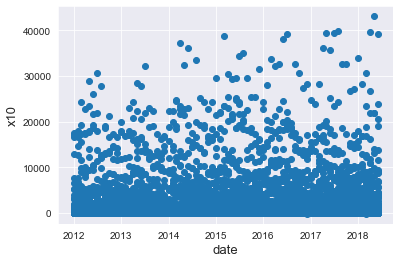

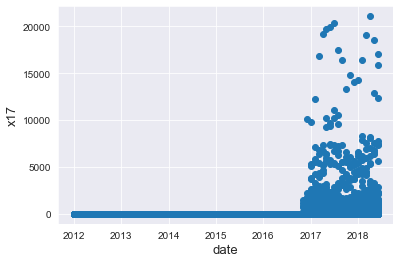

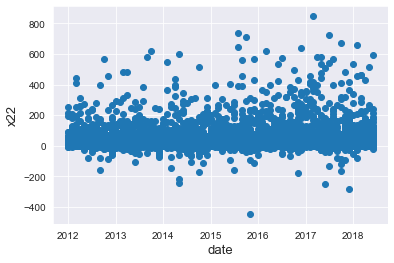

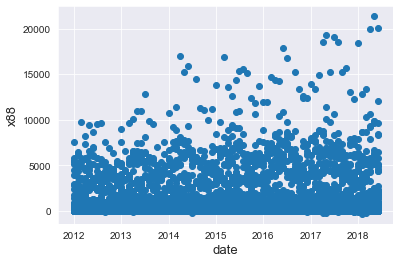

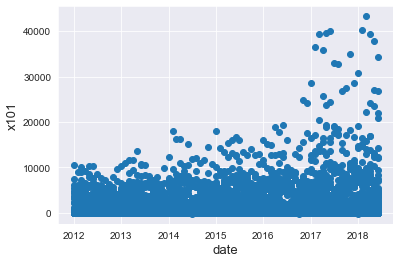

In [16]:
variables = ['x10', 'x17', 'x22', 'x88', 'x101']
# print values distribution of each column
for col in variables:
    fig, ax = plt.subplots()
    ax.scatter(x=df['date'], y=df[col])
    plt.ylabel(col, fontsize=13)
    plt.xlabel('date', fontsize=13)
    plt.show()

In [17]:
df.describe()

,x10,x17,x22,x88,x101,y
count,8195.000000,8195.000000,8195.000000,8195.000000,8195.000000,8195.000000
mean,1723.491793,179.799221,21.895186,832.236698,1156.237607,3644.677701
std,4395.498098,1120.267305,65.745547,2009.330286,3014.689189,2171.135252
min,-196.067620,0.000000,-446.651301,-334.142485,-219.233019,0.670722
25%,18.442762,0.000000,0.000000,8.780626,14.192549,1924.505847
50%,171.102975,0.000000,0.549692,70.710872,127.763668,3368.250213
75%,919.630178,0.000000,10.517924,444.418921,689.956719,5068.173233
max,43112.658610,21083.263700,847.453675,21353.003050,43265.238450,9996.936031


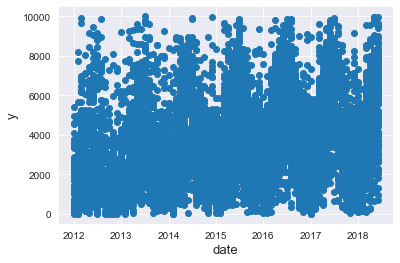

In [18]:
# check the distribution of target value
fig, ax = plt.subplots()
ax.scatter(x=df['date'], y=df['y'])
plt.ylabel('y', fontsize=13)
plt.xlabel('date', fontsize=13)
plt.show()

There isn't any value that could be classified as an outlier so we will not be removing any rows.


 mu = 3644.68 and sigma = 2171.00



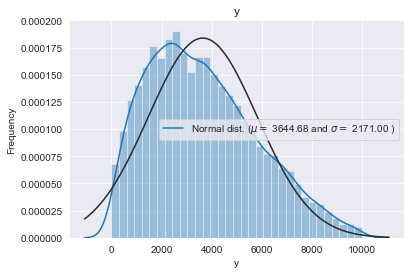

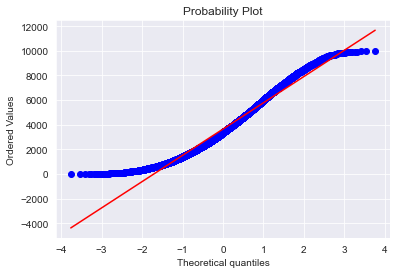

In [19]:
# more target variable analysis
sns.distplot(df['y'], fit=norm)

(mu, sigma) = norm.fit(df['y'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
           loc='best')
plt.ylabel('Frequency')
plt.title('y')

# Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['y'], plot=plt)
plt.show()

After checking the distribution of target variable 'y' we can see that the data is skewed and it is far from the normal distribution.
<br> Linear models want to have the normal distribution of values to make correct predictions so it needs to be changed so the distribution of 'y' can be more normal-like.
<br> All the values in this column will be transformed using the natural logarithm.


 mu = 7.95 and sigma = 0.86



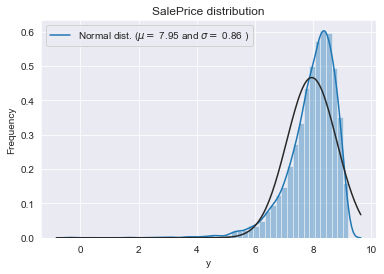

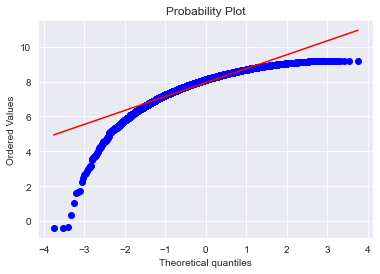

In [20]:
# correct skewed distribtion 
df["y"] = np.log(df["y"])

# Check the new distribution
sns.distplot(df['y'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['y'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
           loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['y'], plot=plt)
plt.show()

In [21]:
df.describe()

,x10,x17,x22,x88,x101,y
count,8195.000000,8195.000000,8195.000000,8195.000000,8195.000000,8195.000000
mean,1723.491793,179.799221,21.895186,832.236698,1156.237607,7.948228
std,4395.498098,1120.267305,65.745547,2009.330286,3014.689189,0.855860
min,-196.067620,0.000000,-446.651301,-334.142485,-219.233019,-0.399401
25%,18.442762,0.000000,0.000000,8.780626,14.192549,7.562424
50%,171.102975,0.000000,0.549692,70.710872,127.763668,8.122149
75%,919.630178,0.000000,10.517924,444.418921,689.956719,8.530736
max,43112.658610,21083.263700,847.453675,21353.003050,43265.238450,9.210034


Now it has a much better distribution looking at the mean and standard deviation.
<br> We will check and correct the skewness of other input variables in train and test data.

In [22]:
# this block measures skewness of each numerical variables in train data
numeric_feats = df.dtypes[df.dtypes != "datetime64[ns]"].index
numeric_feats = numeric_feats[:-1]
skewed_feats = df[numeric_feats].apply(
    lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness


Skew in numerical features: 



,Skew
x17,10.824708
x101,5.728157
x22,4.772527
x10,4.196788
x88,3.947477


In [23]:
# same for test data
X_test['date'] = X_test['date'].astype(int).map(dt.datetime.fromordinal)
numeric_feats_test = X_test.dtypes[X_test.dtypes != "datetime64[ns]"].index

# Check the skew of all numerical features
skewed_feats_test = X_test[numeric_feats_test].apply(
    lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness_test = pd.DataFrame({'Skew': skewed_feats_test})
skewness_test


Skew in numerical features: 



,Skew
x22,10.464408
x17,4.468835
x101,4.068532
x10,3.908416
x88,3.754716


In [24]:
# Box cox transformation of highly skewed features
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(
    skewness.shape[0]))


skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    df[feat] = boxcox1p(df[feat], lam)

There are 5 skewed numerical features to Box Cox transform


In [25]:
skewness_test = skewness_test[abs(skewness_test) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(
    skewness_test.shape[0]))

skewed_features_test = skewness_test.index
lam = 0.15
for feat in skewed_features_test:
    #all_data[feat] += 1
    X_test[feat] = boxcox1p(X_test[feat], lam)

There are 5 skewed numerical features to Box Cox transform


In [26]:
df.head()

,date,x10,x17,x22,x88,x101,y
0,2012-01-01,15.694674,0.0,NaN,15.417891,14.870406,7.265650
2,2012-03-01,15.187546,0.0,6.009578,14.769506,15.704263,8.534745
3,2012-04-01,16.000670,0.0,6.279838,15.616118,14.671644,7.950769
4,2012-05-01,15.008830,0.0,6.095775,14.605267,16.169616,3.937919
5,2012-06-01,16.376968,0.0,8.292410,15.868111,14.846569,7.716488


In [27]:
X_test.head()

,date,x10,x17,x22,x88,x101
0,2018-07-01,18.803870,11.500885,4.206461,17.902143,18.639936
1,2018-08-01,18.561236,12.014724,4.986038,17.717825,16.268784
2,2018-09-01,16.177154,11.646199,4.625659,15.306923,17.501203
3,2018-10-01,17.445929,11.898786,5.157265,16.680632,17.198680
4,2018-11-01,16.919605,12.409987,8.659149,15.970732,17.810014


After correcting distributions, we have to fill missing values again.

In [28]:
# Check remaining missing values if any
df_na = (df.isnull().sum() / len(df)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': df_na})
missing_data.head()

,Missing Ratio
x22,4.417328
x88,1.366687
x101,0.854179
x10,0.536913


In [29]:
X_test_na = (X_test.isnull().sum() / len(X_test)) * 100
X_test_na = X_test_na.drop(
    X_test_na[X_test_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': X_test_na})
missing_data.head()

,Missing Ratio
x22,4.691877
x88,1.680672
x10,1.050420
x101,0.980392


In [30]:
# fill missing values again
df = df.fillna(0)
X_test = X_test.fillna(0)

## Predicting the sales

Before we start making prediction models we want to declare the function to measure the error of predictions which is used and interpreted by the business unit.
<br>It is mean absolute error expressed as a percentage.
<br>It is important for the 'y_true' value not to be zero because the metric will not divide by this number.

In [31]:
# function to calculate WMAPE, which is error metric used by buiness unit
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
# Preparing dataframe for predictions
y_train = df.y.values
df['date'] = df['date'].map(dt.datetime.toordinal)
X_test['date'] = X_test['date'].map(dt.datetime.toordinal)
df.drop('y', axis=1, inplace=True)

After needed preparation, we can now start making prediction models.
<br>Conducted experiments showed that Random Forest regressor presents always the lowest error among tested algorithms, so final tests & predictions will be presented only on that one.
<br>First, we need to find the best suiting parameters for Random Forest Regressor on our data. To achieve that, we will use the Randomized Search cross-validation method.
<br>We provided the parameters grid to find the best estimator between them.

In [37]:
# using Randomized seach cross validation to find best fitted random forest regressor parameters for our data

# this is parameter distribution for function to use
param_rf = {'bootstrap': [True, False], 'max_depth': [4, 5, 6, 7, 8, 20, 40, 60, 70, 80, 90, 100, None], 'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [8, 9, 10, 12, 14, 16, 18, 20], 'min_samples_split': [18, 20, 24, 26, 28, 30, 32, 34, 36, 40], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200]} 
tscv = TimeSeriesSplit(n_splits=5)
rs_rf = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=111, n_jobs=-1),
                           param_distributions=param_rf, n_iter=40, cv=tscv, scoring='r2', verbose=1, n_jobs=-1) # random search object init
rs_rf.fit(df, y_train)
best = rs_rf.best_params_ # save the best parameters for regression

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.2min finished


Chosen parameters are passed to the final regressor and we can now compare different scores to see how well it predicts

In [38]:
best

{'n_estimators': 1800,
 'min_samples_split': 40,
 'min_samples_leaf': 20,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

In [39]:
# I don't retrain model from code above for quicker reuse
rfr = RandomForestRegressor(n_estimators=1800, min_samples_split=40, min_samples_leaf=20,
                            max_features='auto', max_depth=90, bootstrap=True, random_state=111, n_jobs=-1) # we use parameters printed above for final model
rfr.fit(df, y_train)

# making preditions and calculating errors
y_pred = rfr.predict(df)
mape = mean_absolute_percentage_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
score = r2_score(y_train, y_pred)
print('WMAPE score: ', mape)
print('R2 scpre: ', score)
print('MAE score: ', mae)

WMAPE score:  7.336303840150496
R2 scpre:  0.4134274068652867
MAE score:  0.45529380028547145


We achieved a 7.33% WMAPE value which is very low and can be accepted as final.
<br> We have to check how well the model behaves on data which it didn't see to be sure we achieved a decent variance-bias tradeoff.|

In [40]:
'''
Cell below isn't necessarily correct because of time series split.
Overfitting should have been delt during RandomSearchCV using TimeSeriesSplit method
'''
# repeating predictions on validation set to make sure model doesnt overfit
# rfr = RandomForestRegressor(n_estimators=1000, min_samples_split=40, min_samples_leaf=14,
#                             max_features='auto', max_depth=80, bootstrap=True, random_state=111, n_jobs=-1)
# # X_train_check, X_test_check, y_train_check, y_test_check = train_test_split(
# #     df, y_train, test_size=0.15, random_state=111)

# tscv = TimeSeriesSplit(n_splits=5)
# for tr_idx, val_idx in tscv.split(df):
#     X_tr, X_val = df[tr_idx,], df[val_idx, :]
#     y_tr, y_val = y_train[tr_idx], y_train[val_idx]

# # rfr_ch.fit(X_train_check, y_train_check)
# # y_pred_train = rfr_ch.predict(X_train_check)
# # print('mape train: ', mean_absolute_percentage_error(y_train_check, y_pred_train))
# # print('r2 train: ', r2_score(y_train_check, y_pred_train))
# # print('mae train: ', mean_absolute_error(y_train_check, y_pred_train))
# # print('///////////////////////')
# # y_pred_test = rfr_ch.predict(X_test_check)
# # print('mape test: ', mean_absolute_percentage_error(y_test_check, y_pred_test))
# # print('r2 test: ', r2_score(y_test_check, y_pred_test))
# # print('mae test: ', mean_absolute_error(y_test_check, y_pred_test))
# # print('///////////////////////')
# rfr_ch.fit(X_tr, y_tr)
# y_pred_train = rfr_ch.predict(X_tr)
# print('mape train: ', mean_absolute_percentage_error(y_tr, y_pred_train))
# print('r2 train: ', r2_score(y_tr, y_pred_train))
# print('mae train: ', mean_absolute_error(y_tr, y_pred_train))
# print('///////////////////////')
# y_pred_test = rfr_ch.predict(X_val)
# print('mape test: ', mean_absolute_percentage_error(y_val, y_pred_test))
# print('r2 test: ', r2_score(y_val, y_pred_test))
# print('mae test: ', mean_absolute_error(y_val, y_pred_test))
# print('///////////////////////')

"\nBelow isn't necessarily correct because of time series split.\nOverfitting should have been delt during RandomSearchCV using TimeSeriesSplit method\n"

Errors on test and train data are very close so we can safely make final predictions and save them to file.

In [192]:
# saving final predictions in prepared file

Y_test = pd.read_csv('Y_test.csv', sep=';')
Y_test['y'] = Y_test['y'].apply(lambda x: str(x).replace(',', '.'))
Y_test['y'] = Y_test['y'].astype('float')
Y_test['date'] = pd.to_datetime(Y_test['date'])
y_test = rfr_ch.predict(X_test)
y_test = np.exp(y_test)
Y_test['y'] = y_test
Y_test.to_csv('Y_test_preds.csv')

Predicted sales are presented in the attached Power BI file and can be analyzed further there.
<br> This concludes my analsis.